/home/xix22010/anaconda3/lib/python3.9/site-packages/torch_sparse/storage.py:14: UserWarning: `layout` argument unset, using default layout "coo". This may lead to unexpected behaviour.
  warnings.warn('`layout` argument unset, using default layout '


[332, 340]
[330, 335]
[338, 341]
[346, 346]
plotting 0 channel
plotting 1 channel
plotting 2 channel
plotting 3 channel
plotting 0 channel
plotting 1 channel
plotting 2 channel
plotting 3 channel


/home/xix22010/anaconda3/lib/python3.9/site-packages/torch_sparse/storage.py:14: UserWarning: `layout` argument unset, using default layout "coo". This may lead to unexpected behaviour.
  warnings.warn('`layout` argument unset, using default layout '


[338, 335]
[346, 341]
[332, 346]
[340, 330]
plotting 0 channel
plotting 1 channel
plotting 2 channel
plotting 3 channel
plotting 0 channel
plotting 1 channel
plotting 2 channel
plotting 3 channel
draw end


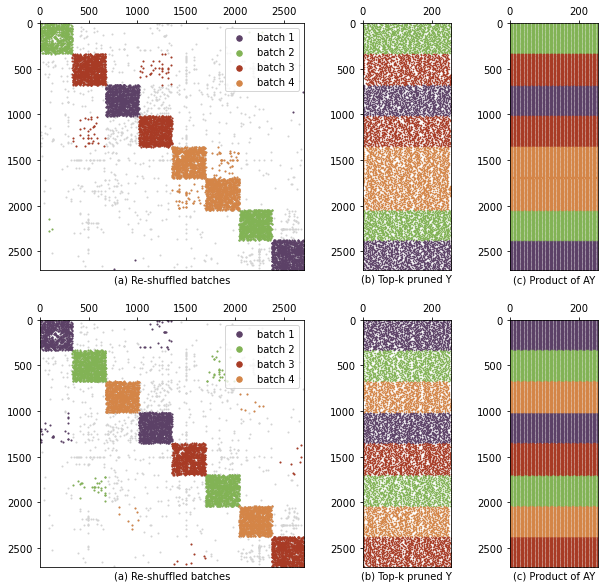

In [1]:
import torch
import copy
from torch_sparse import SparseTensor, cat
import random
import io, pickle
from matplotlib import gridspec
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import ClusterData
import torch

_colors = [[11, 132, 165],[246, 200, 95], [111, 78, 124], [157, 216, 102],[202, 71, 45],[255, 160, 86],[141, 221, 208], [159, 2, 81]]
colors = [np.array(_color) / 1.2 / 256 for _color in _colors]

with io.open('tmp_DICT3411', 'rb') as f:
    DICT = pickle.load(f)

n_part = 8
resample = 20
dataset = Planetoid("./dataset", 'Cora')
data = dataset[0]
cluster_data = ClusterData(data, num_parts=n_part, recursive=False, save_dir=dataset.processed_dir)

def ReLU(x):
    return x * (x > 0)

def draw_adj(ax:plt.Axes, x_label=""):
    sci_adj = cluster_data.data.adj.to_scipy()
    ax.scatter(sci_adj.row, sci_adj.col, s=1, color='lightgray')
    for b in range(n_part//2):
        batch = bn[b]
        start = cluster_data.partptr[batch].tolist()
        end = cluster_data.partptr[batch + 1].tolist()
        node_idx = torch.cat([torch.arange(s, e) for s, e in zip(start, end)])
        data = copy.copy(cluster_data.data)
        adj = cluster_data.data.adj
        _len = []
        for i in range(len(start)):
            _len.append(end[i] - start[i])
        print(_len)
        for i in range(len(start)):
            for j in range(len(start)):
                row, col, _ = adj[start[i]:end[i],start[j]:end[j]].coo()
                _row = row + start[i]
                _col = col + start[j]
                if i == 0 and j == 0:
                    ax.scatter(_row, _col, s=1, color=colors[b+2], label='batch '+ str(b+1))
                else:
                    ax.scatter(_row, _col, s=1, color=colors[b+2])
                # density = len(row) / (_len[i]*_len[j])
                # props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
                # ax.text(start[i], start[j] + _len[j] // 2, f'{density:.5f}', c='black', bbox=props)
                
                # print('shape', _len[i], _len[j], 'density',)

        
    ax.xaxis.set_ticks_position('top')
    ax.set_xlim(0,2708)
    ax.set_ylim(2708,0)
    lgnd = plt.legend(loc="upper right", numpoints=2)
    for i in range(n_part//2):
        lgnd.legendHandles[i]._sizes = [30]
    ax.set_xlabel(x_label)
    

def draw_256(ax:plt.Axes, matrixss, relu = False, x_label = ""):
    for b in range(n_part//2):
        print('plotting', b, 'channel')
        matrix = matrixss[b][0]
        if isinstance(matrix, torch.Tensor):
            matrix = matrix.cpu().detach().numpy()
        if relu:
            matrix = ReLU(matrix)
        start = cluster_data.partptr[bn[b]].tolist()
        end = cluster_data.partptr[bn[b] + 1].tolist()
        pos = [0]
        pe = 0
        for i in range(len(start)):
            pe += end[i] - start[i]
            pos.append(pe)

        for i in range(len(start)):
            m_part = matrix[pos[i] : pos[i+1]]
            row, col, value = SparseTensor.from_dense(torch.tensor(m_part)).coo()
            row += start[i]
            ax.plot(col[::resample], row[::resample], '.', markersize=1, c=colors[b+2])
            
            # density = len(row) / (m_part.shape[0] * m_part.shape[1])
            # props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
            # ax.text(0, start[i] + m_part.shape[0]//2, f'{density:.5f}', c='black', bbox=props)

    ax.xaxis.set_ticks_position('top')
    ax.set_xlim(0, 255)
    ax.set_ylim(2708, 0)
    ax.set_xlabel(x_label)

ep = 2

fig = plt.figure(figsize = (10, ep*5))
gs = gridspec.GridSpec(ep, 3, width_ratios=[3, 1, 1], wspace=0.4) 

epoch_number = range(1, ep + 1)
for i, epoch in enumerate(range(ep)):
    _epoch = epoch + 1
    bn = DICT['Cora', 0.4, 0.5, 'public'][2][_epoch]
    xws = DICT['Cora', 0.4, 0.5, 'public'][0][_epoch * n_part//2 : (_epoch+1) * n_part//2]
    outs = DICT['Cora', 0.4, 0.5, 'public'][1][_epoch * n_part//2 : (_epoch+1) * n_part//2]
    if i == 0:
        adj_label = "(a) Re-shuffled batches"
    else:
        adj_label = "(a) Re-shuffled batches"
    draw_adj(plt.subplot(gs[0 + epoch*3]), x_label=adj_label)
    draw_256(plt.subplot(gs[1 + epoch*3]), xws, x_label="(b) Top-k pruned Y")
    draw_256(plt.subplot(gs[2 + epoch*3]), outs, x_label="(c) Product of AY")
    # draw_256(plt.subplot(gs[3 + epoch*4]), outs, relu=True, x_label="AXW after ReLU")

print('draw end')
fig.savefig('axw_2epoch.png', format='png')
